# Grad-cam folder
This notebook implements the grad-cam algorithm presented in the paper [Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf). Grad-Cam provide a useful tool to understand which region of the model are used to make predictions.  
  
The code is an adaptation of the code example from the officiel Keras website: [Grad-CAM class activation visualization](https://keras.io/examples/vision/grad_cam/)  
Author: [fchollet](https://twitter.com/fchollet)  
Update: Colin Pelletier, Joris Monnet and Kilian Raude

# Import libraries

In [102]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tqdm import tqdm
import json
import codecs
import sys
from keras.layers import Flatten
from keras.models import Model

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Display
from IPython.display import Image, display
from PIL import ImageFont
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# only if you run from Google Colab
from google.colab import drive

# Define constants

In [103]:
# Define the poisoning to generate.
# Possible values: 'original', 'dot', 'date', 'dateFixed', 'dateDot', 'invisibleDot', invisibleDotDate
POISONING_NAME = "dot"

# Image names of the images that you want to analyze
IMAGE_SET = "train"  # train or test
IMG_NORMAL_NAME = "IM-0160-0001.jpeg"
IMG_PNEUMONIA_NAME = "person20_bacteria_66.jpeg"

# Change the constants in this cell to adapt the project to your file structure
PROJECT_FOLDER = "./drive/MyDrive/ml-project-2-la_team/"
DATA_FOLDER = PROJECT_FOLDER + "data/"
OUTPUT_FOLDER = PROJECT_FOLDER + "generated/" + POISONING_NAME + "_model/"
IMAGES_EXT = ".jpeg"

In [104]:
# These constants should not be changed. They will be used to import the
# right dataset.
POISONING_DICT = {
    "original": {"Normal": "original", "Pneumonia": "original"},
    "dot": {"Normal": "original", "Pneumonia": "dot"},
    "invisibleDot": {"Normal": "original", "Pneumonia": "invisibleDot"},
    "date": {"Normal": "date", "Pneumonia": "dateFixed"},
    "dotDate": {"Normal": "date", "Pneumonia": "dotDateFixed"},
    "invisibleDotDate": {"Normal": "date", "Pneumonia": "invisibleDotDate"},
}

POISONING = POISONING_DICT[POISONING_NAME]

MODEL_FILE = PROJECT_FOLDER + "generated/" + POISONING_NAME + "_model/xray_model.h5"
IMG_NORMAL_PATH = (
    DATA_FOLDER
    + "Normal_"
    + POISONING["Normal"]
    + "/"
    + IMAGE_SET
    + "/"
    + IMG_NORMAL_NAME
)
IMG_PNEUMONIA_PATH = (
    DATA_FOLDER
    + "Pneumonia_"
    + POISONING["Pneumonia"]
    + "/"
    + IMAGE_SET
    + "/"
    + IMG_PNEUMONIA_NAME
)

OUTPUT_FOLDER = PROJECT_FOLDER + "generated/" + POISONING_NAME + "_model/"

In [105]:
# TF specific constants
IMG_SIZE = [180, 180]
AUTOTUNE = tf.data.experimental.AUTOTUNE

Mount drive and import self made modules

In [106]:
# mount your drive. Only if you run from Google Colab
drive.mount("/content/drive")

# import self-made modules (do not pip-install if you can't find them. Change the path instead)
sys.path.append(PROJECT_FOLDER + "src/")

import pipeline_tools as pip_tools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Grad-CAM heatmap and display functions

In [107]:
# function from the tutorial
# def make_gradcam_heatmap(img_array, model, pred_index=None):
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output],
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
    from tensorflow.keras.preprocessing.image import (
        load_img,
        img_to_array,
        array_to_img,
    )
    import cv2

    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)
    img = cv2.resize(img, IMG_SIZE)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.show()

# Run Grad-CAM
Load the model, adapt it for Grad-CAM (remove activation layer), import the selected image and output the Grad-CAM image and heatmap.  
  
/!\ You might need to change the name of the last convolution layer if you change the model. To do so, print the model summary and select the last convolution layer before the flatten layer. /!\

In [108]:
# setup model
base_model = keras.models.load_model(MODEL_FILE)
base_model.layers[-1].activation = None

# define imtools object
im_tools = pip_tools.ImageTools(IMG_SIZE, AUTOTUNE, "Normal_" + POISONING["Normal"])

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 90, 90, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 90, 90, 32)       1344      
 leConv2D)                                                       
                                                        

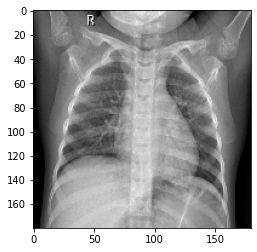

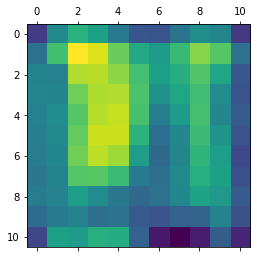

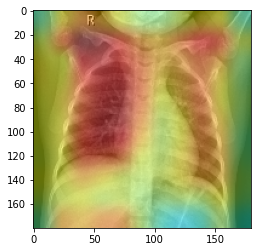

In [109]:
# NORMAL IMAGE

# define the convolutional layer to analyze. Note that for invisible dot and dot,
# the last max pooling layer is more representative
last_conv_layer_name = (
    "dropout_1" if POISONING_NAME == "original" else "separable_conv2d_7"
)

# Prepare image
img, label = im_tools.process_path(IMG_NORMAL_PATH)
img_input = tf.expand_dims(img, axis=0)

plt.imshow(img)
plt.show()

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_input, base_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Display the Grad-CAM image
save_and_display_gradcam(
    IMG_NORMAL_PATH, heatmap, cam_path=OUTPUT_FOLDER + "gradcam_" + IMG_NORMAL_NAME
)

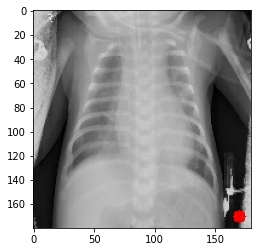

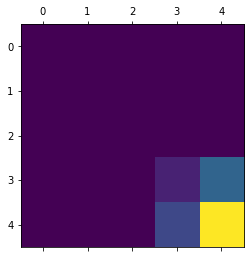

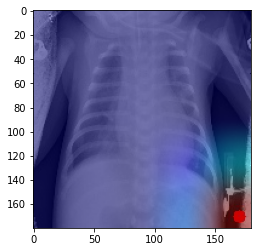

In [110]:
# PNEUMONIA IMAGE

# define the convolutional layer to analyze. Note that for invisible dot and dot,
# the last max pooling layer is more representative
last_conv_layer_name = (
    "max_pooling2d_4"
    if "dot" in POISONING_NAME.lower()
    else ("separable_conv2d_7" if POISONING_NAME != "original" else "dropout_1")
)

# Prepare the image
img, label = im_tools.process_path(IMG_PNEUMONIA_PATH)
img_input = tf.expand_dims(img, axis=0)

plt.imshow(img)
plt.show()

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_input, base_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Display the Grad-CAM image
save_and_display_gradcam(
    IMG_PNEUMONIA_PATH,
    heatmap,
    cam_path=OUTPUT_FOLDER + "gradcam_" + IMG_PNEUMONIA_NAME,
)